In [165]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import numpy as np
import pandas as pd
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset, repeat_channels
from metrics import compute_metrics
from training import train
from evaluation import plot_spectrogram_slices, plot_spectrograms, plot_spectrogram_with_predictions
from torch.utils.data._utils.collate import default_collate
from sklearn.model_selection import train_test_split, KFold

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [106]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 100  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.55  # overlap between consecutive windows



indices = np.arange(94)
# split the dataset into train/validation and test sets
train_val_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)
# split the dataset into train and validation sets
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)
print("Train indices:", list(train_indices))
print("Val indices:", list(val_indices))
print("Test indices:", list(test_indices))

train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                   file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                   overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_indices)
val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=default_collate, num_workers=0)

Train indices: [86, 6, 43, 68, 27, 38, 7, 65, 29, 4, 87, 19, 53, 36, 51, 66, 59, 28, 37, 84, 77, 1, 16, 64, 30, 32, 62, 69, 17, 49, 79, 18, 24, 74, 57, 50, 56, 92, 11, 34, 73, 45, 54, 47, 89, 71, 82, 41, 76, 60, 48, 88, 2, 3, 80, 35, 46, 70, 90, 42, 20, 85, 9, 81, 21, 33, 75]
Val indices: [23, 83, 58, 5, 78, 52, 15, 31, 12, 63, 8, 93, 13, 14, 91, 61, 25]
Test indices: [40, 22, 55, 72, 0, 26, 39, 67, 10, 44]


Processing dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 3961
Shot numbers: [72966, 64401, 70390, 71292, 64770, 70382, 64646, 71264, 64778, 64392, 72967, 64673, 71192, 70380, 71189, 71265, 71225, 64774, 70381, 72964, 72927, 64376, 64666, 71260, 64820, 70355, 71256, 71300, 64668, 71186, 72929, 64670, 64682, 72920, 71223, 71188, 71222, 73022, 64650, 70357, 72919, 70392, 71193, 70394, 73019, 72196, 72961, 70388, 72926, 71226, 71182, 73018, 64378, 64389, 72930, 70359, 70393, 71303, 73020, 70389, 64675, 72965, 64648, 72959, 64677, 70356, 72925]


Processing dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 938
Shot numbers: [64680, 72963, 71224, 64394, 72928, 71190, 64664, 64834, 64658, 71259, 64647, 73023, 64659, 64662, 73021, 71255, 64684]


In [107]:
j = 0
for i in range(len(train_loader.dataset) - 1):
    j += train_loader.dataset[i]['label']
pos_proportion = j / len(train_loader.dataset)
print(f"proportion of positive samples in train set: {pos_proportion.item():.3%}, {1/pos_proportion.item():.3f}")

proportion of positive samples in train set: 18.228%, 5.486


In [108]:
# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True, drop_rate=0.2)

# replace classifier layer for binary classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 640),  # output one value
    nn.ReLU(),
    nn.Linear(640, 1),
)

summary(model.to('cpu'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

In [109]:
num_epochs = 7

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1/pos_proportion]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

training on device 'mps'


Epoch 0:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.92963, f1: 0.82947, roc-auc: 0.99059
            Test accuracy: 0.89315, f1: 0.60758, roc-auc: 0.96988


Epoch 1:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.97228, f1: 0.92546, roc-auc: 0.99889
            Test accuracy: 0.90828, f1: 0.66902, roc-auc: 0.97460


Epoch 2:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.98589, f1: 0.96367, roc-auc: 0.99988
            Test accuracy: 0.91558, f1: 0.66863, roc-auc: 0.96824


Epoch 3:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.99496, f1: 0.98531, roc-auc: 1.00000
            Test accuracy: 0.92599, f1: 0.68767, roc-auc: 0.96179


Epoch 4:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99773, f1: 0.99375, roc-auc: 1.00000
            Test accuracy: 0.93383, f1: 0.70469, roc-auc: 0.95898


Epoch 5:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 0.99798, f1: 0.99408, roc-auc: 0.99997
            Test accuracy: 0.93120, f1: 0.69946, roc-auc: 0.95930


Epoch 6:   0%|          | 0/62 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 0.99824, f1: 0.99422, roc-auc: 0.99998
            Test accuracy: 0.93016, f1: 0.69780, roc-auc: 0.95908


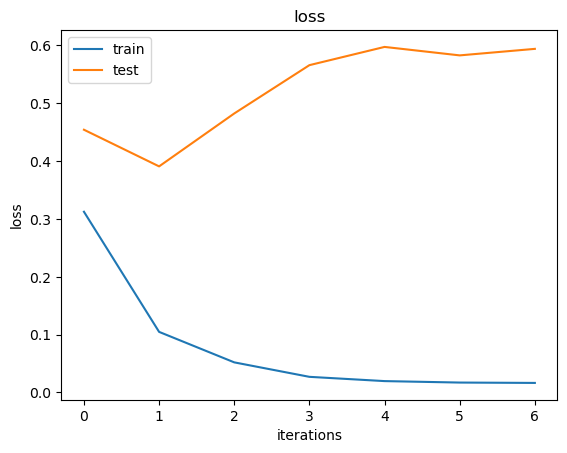

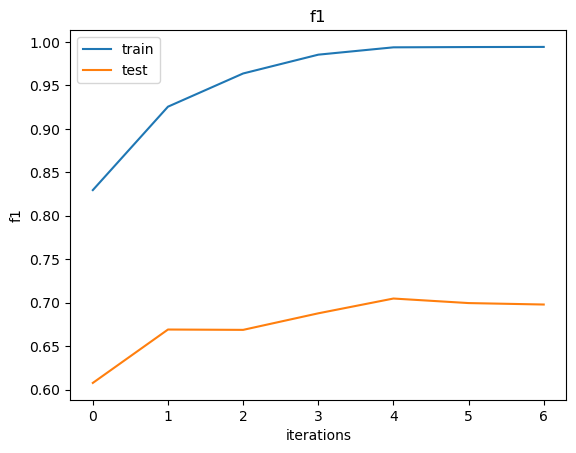

(0.994224209046113, 0.6977961894756439)

In [110]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=num_epochs)

## Evaluating the model & visualizing predictions

In [214]:
WINDOW_SIZE = 100
OVERLAP = OVERLAP_FACTOR
test_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP, transform=transform, shot_filter=test_indices)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/10 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 689
Shot numbers: [70387, 64678, 71194, 72198, 64374, 64686, 70383, 71266, 64649, 70391]


Considering test shots: [71194, 70391]


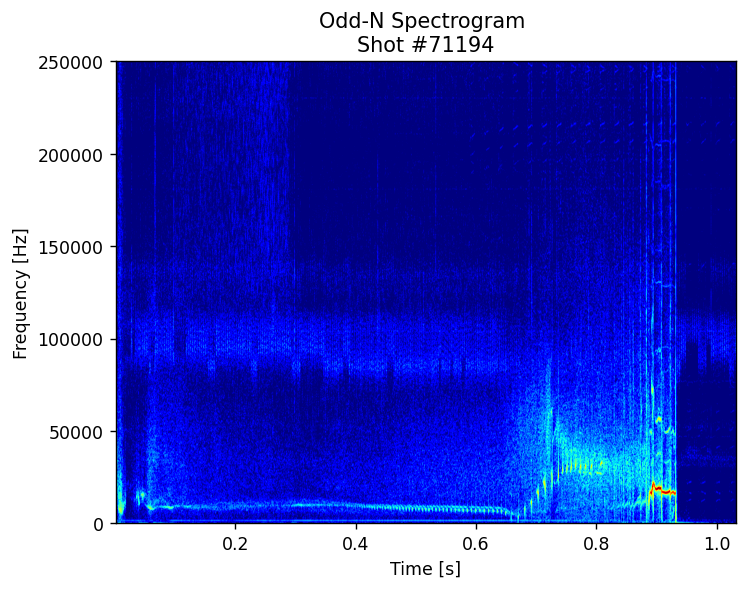

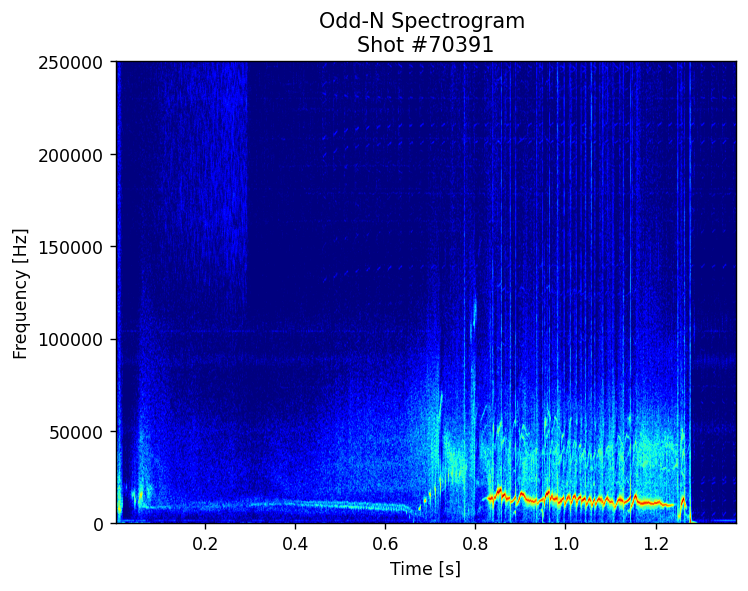

In [215]:
# let's check some random shots from the test set
np.random.seed(1)
shotnos = list(np.random.choice(test_loader.dataset.shotnos, size=2, replace=False))
print(f"Considering test shots: {shotnos}")

plot_spectrograms(shotnos, DATA_PATH, FILE_EXT)

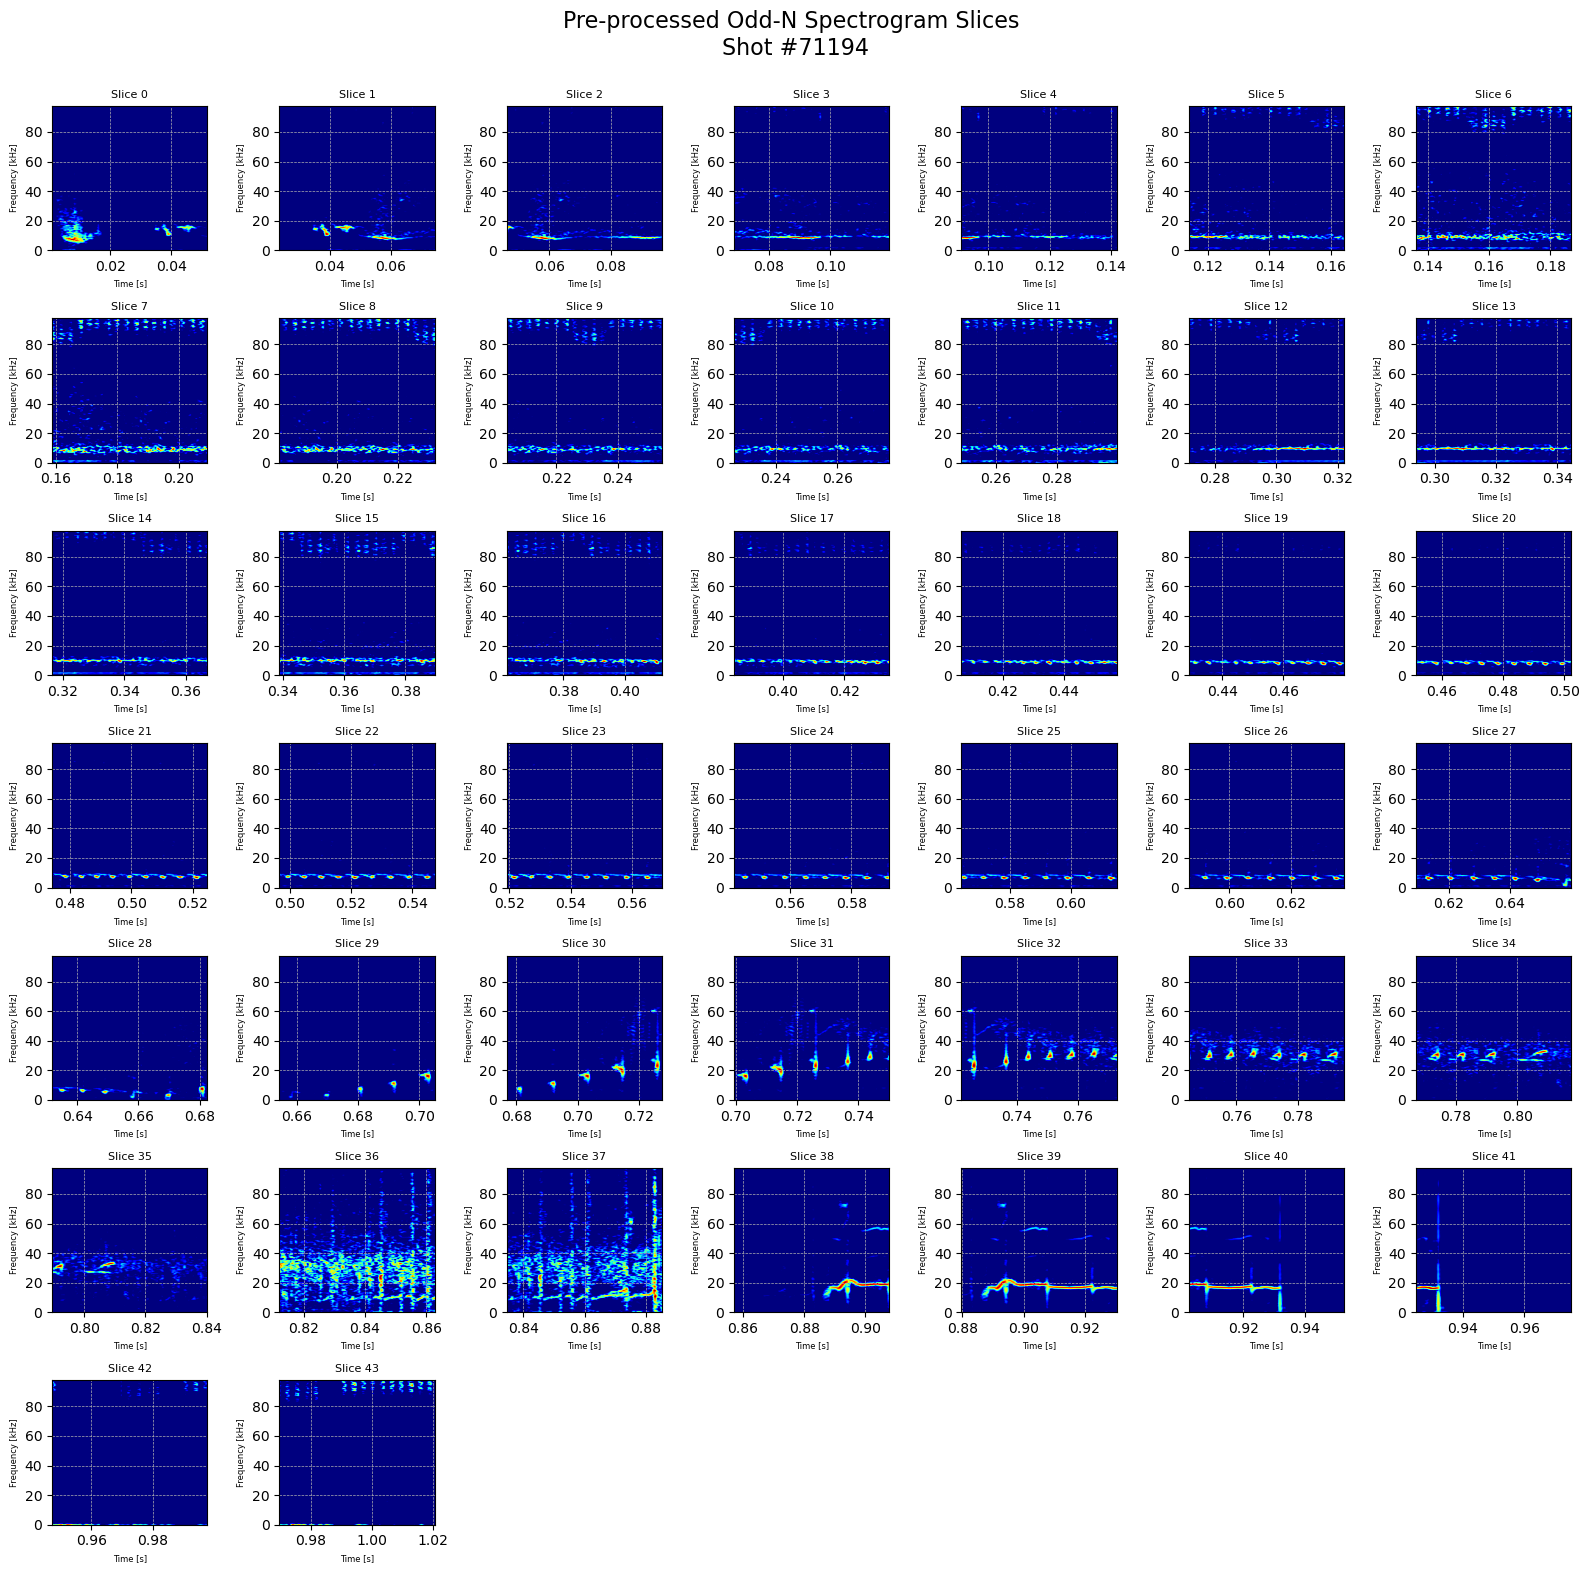

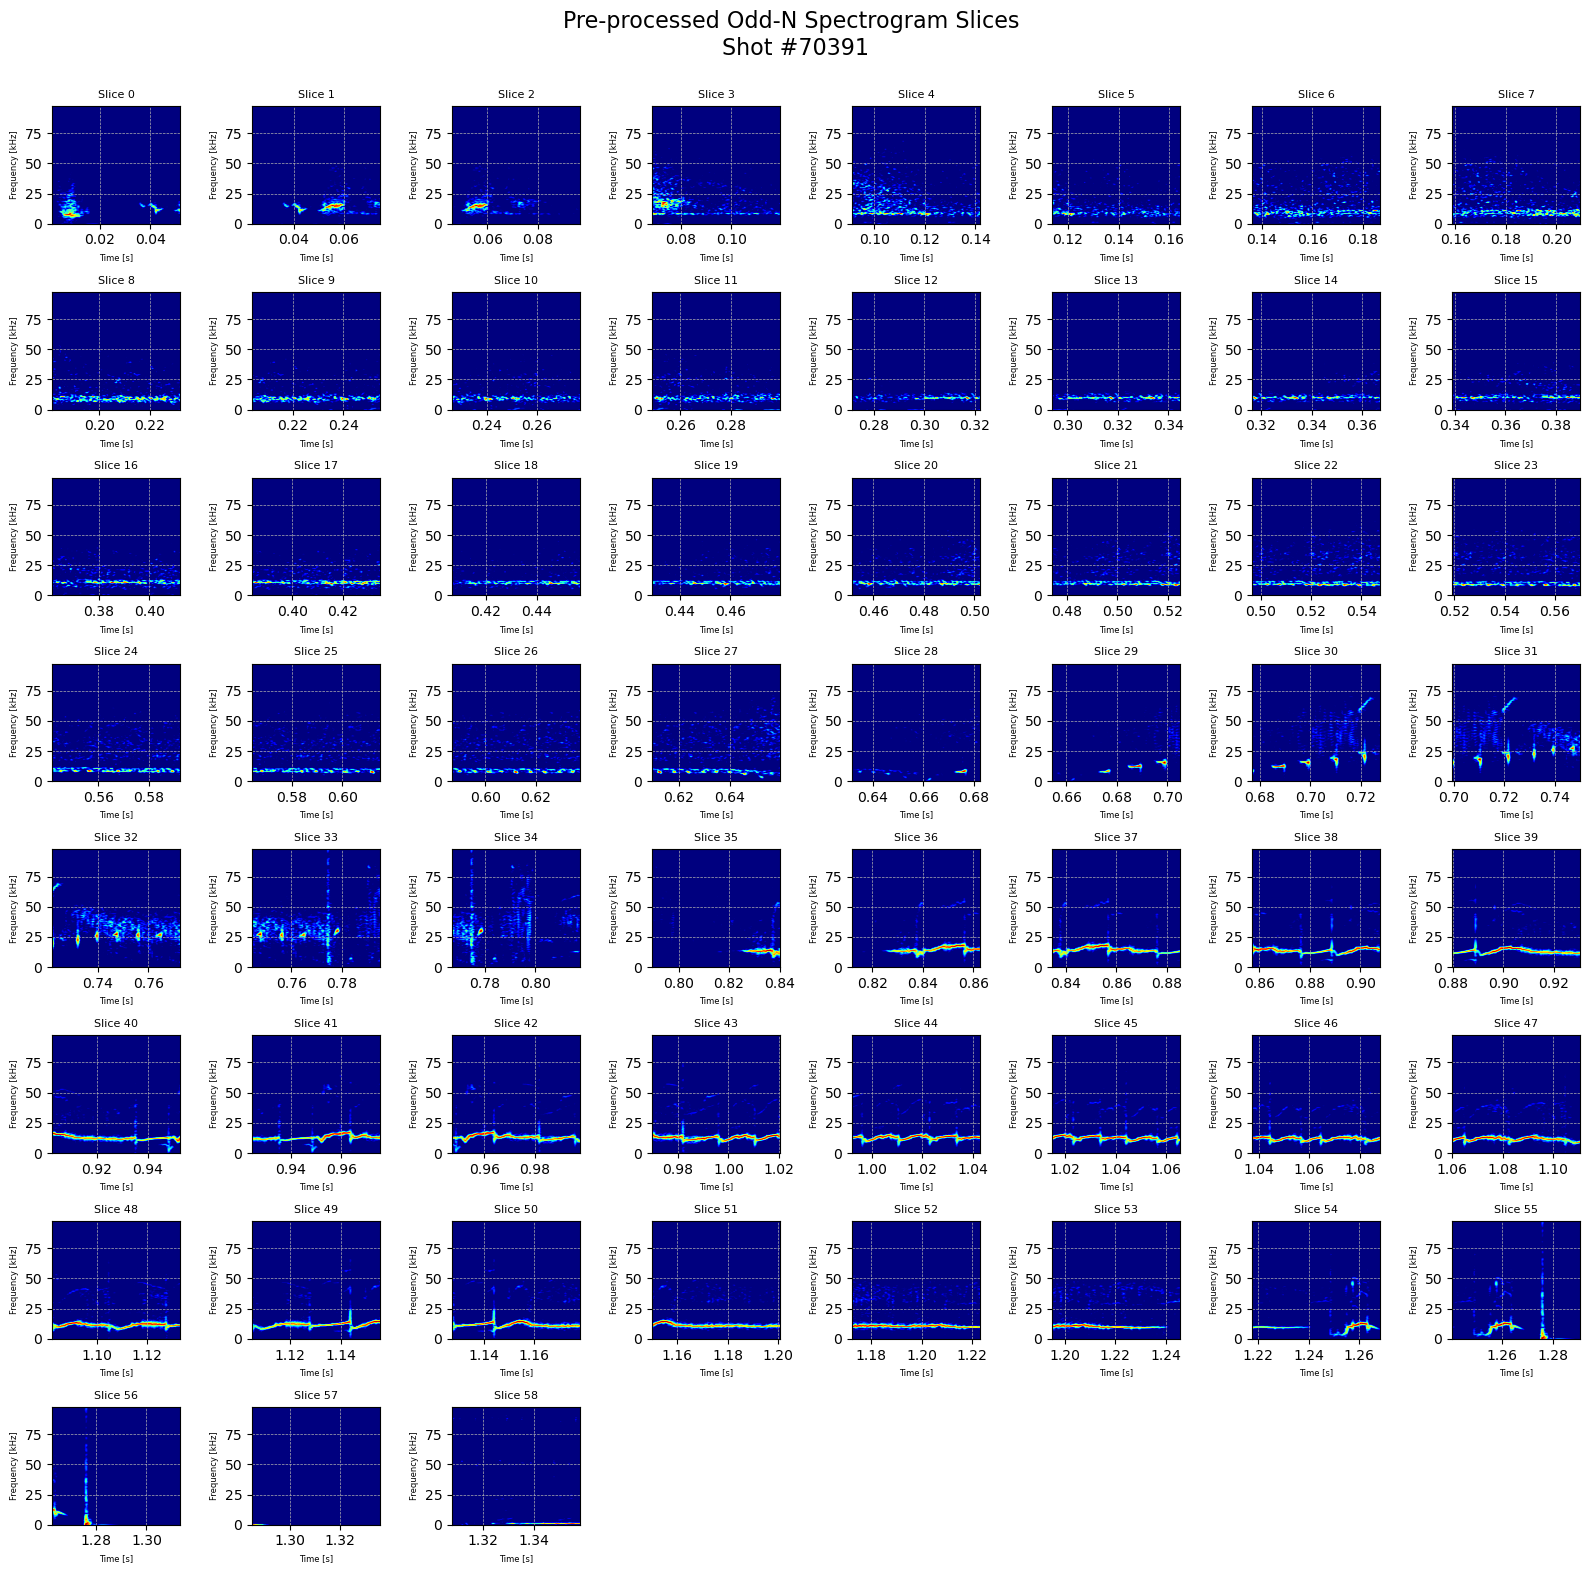

In [216]:
plot_spectrogram_slices(test_loader, shotnos)

Processing 44 slices for shot number 71194


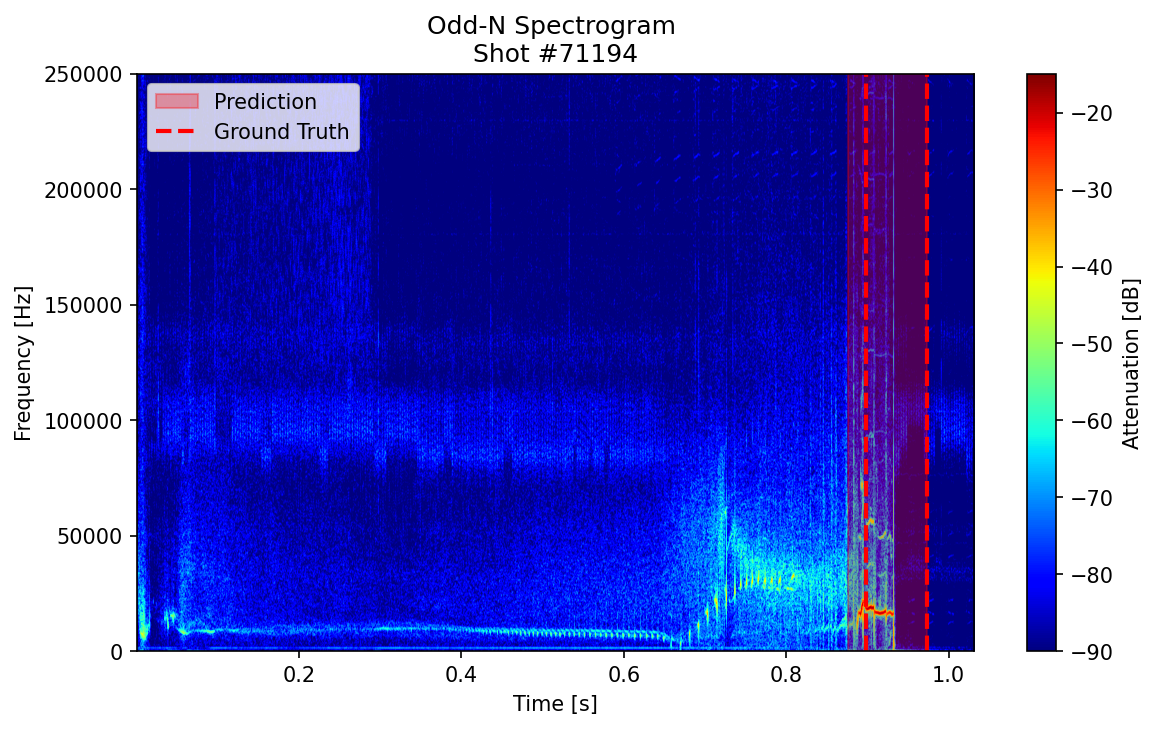

Processing 59 slices for shot number 70391


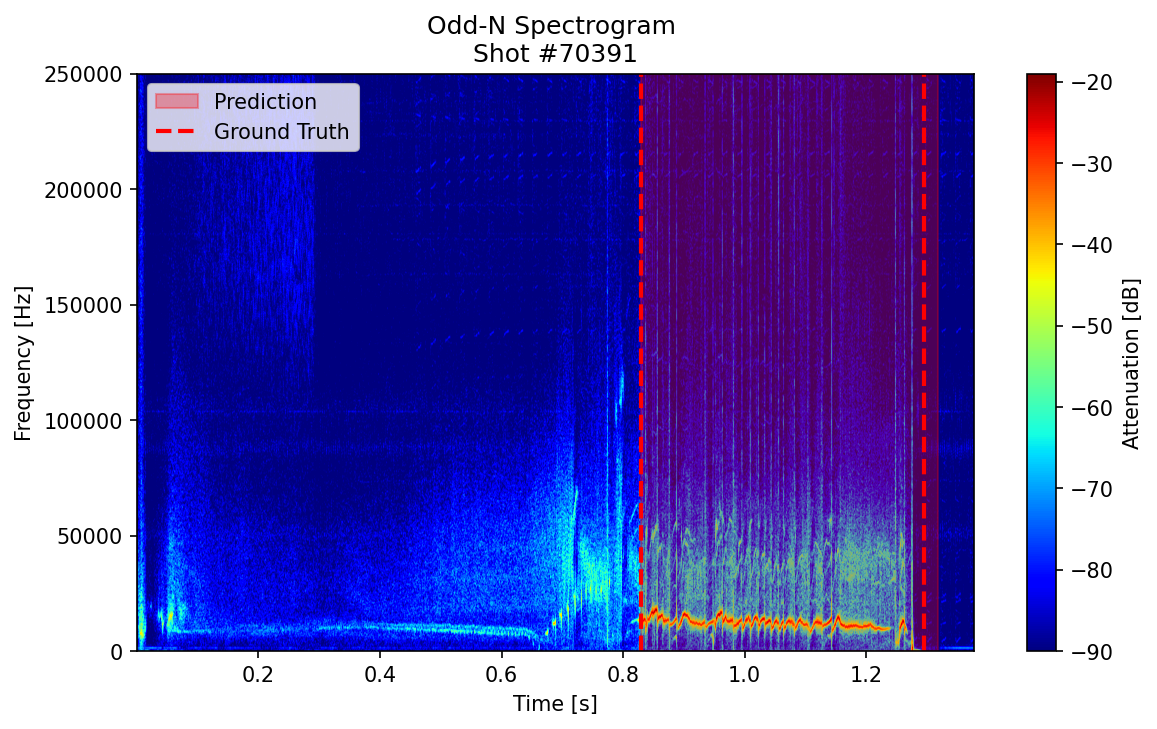

In [217]:
plot_spectrogram_with_predictions(shotnos, DATA_PATH, FILE_EXT, model, test_loader, device, WINDOW_SIZE, OVERLAP, threshold=0.5)